In [8]:
import pickle
import cv2
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import glob
from scipy.misc import imread, imsave

# Undistortion

In [2]:
# Load the camera calibration
with open('camera_cal/calibration.p', "rb") as file:
    calibration = pickle.load(file=file)

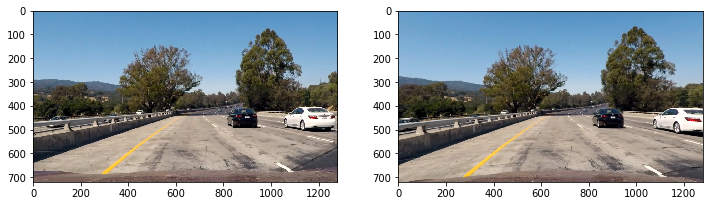

In [9]:
# Undistort a test image
img = imread('test_images/test1.jpg')
dst = cv2.undistort(img, calibration['mtx'], calibration['dist'],
                    None, calibration['mtx'])
imsave('output_images/test1_undistorted.jpg', dst)
figure, axarr = plt.subplots(1, 2, figsize=(12, 6))
axarr[0].imshow(img)
axarr[1].imshow(dst)

# Perspective Transform

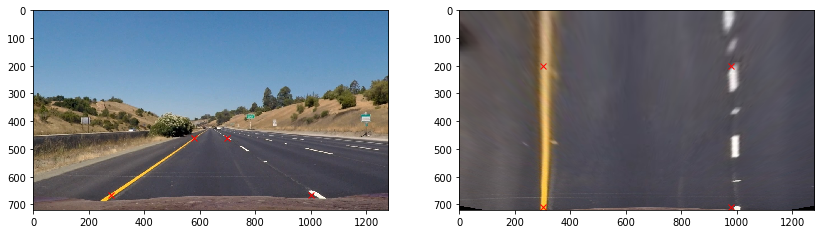

In [87]:
# undistort, then warp using 

# Hardcode source and destination points
srcp = np.float32([(280,667),
                  (580,460),
                  (700,460),
                  (1000,667)])
dstp = np.float32([(300, 710),
                  (300, 200),
                  (980, 200),
                  (980, 710)])

def bridseye(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(srcp, dstp)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undist, M, dsize=(img.shape[1],img.shape[0]))

    # Return the resulting image and matrix
    return warped, M

img = imread('test_images/straight_lines1.jpg')
dst, M = bridseye(img, calibration['mtx'], calibration['dist'])

# Plot results
figure, axarr = plt.subplots(1, 2, figsize=(14, 8))
axarr[0].imshow(img)
for point in srcp:
    axarr[0].plot(point[0],point[1],'rx')
axarr[1].imshow(dst)
for point in dstp:
    axarr[1].plot(point[0],point[1],'rx')
img.shape
imsave('output_images/straight_lines1_bridseye.jpg',dst)

# Gradient Thresholding

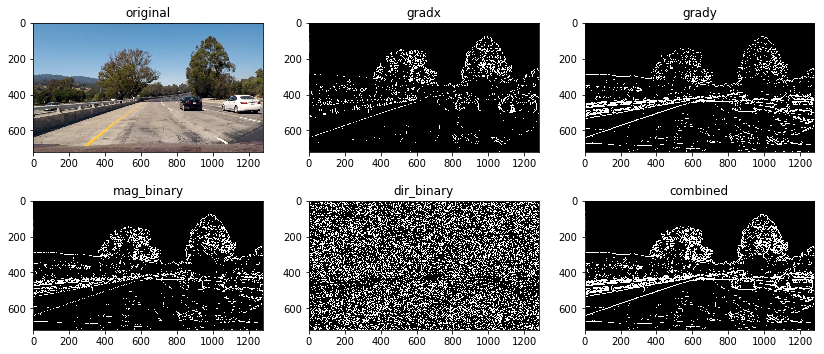

In [102]:
# Gradient thesholding code from the classroom

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Reduce noise in a binary image
def binary_noise_reduction(img, thresh):
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(img, ddepth=-1, kernel=k)
    img[nb_neighbours < thresh] = 0
    return img

image = imread('test_images/test1.jpg')

# Apply each of the thresholding functions
ksize = 7
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(25, 150))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 150))
mag_binary = mag_thresh(image, sobel_kernel=5, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=5, thresh=(0.7, 1.2))

combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
combined[((gradx == 1) | (grady == 1))] = 1
#combined = binary_noise_reduction(combined,3)

figure, axarr = plt.subplots(2, 3, figsize=(14, 6))
axarr[0,0].imshow(image)
axarr[0,0].set_title('original')
axarr[0,1].imshow(gradx,cmap='gray')
axarr[0,1].set_title('gradx')
axarr[0,2].imshow(grady,cmap='gray')
axarr[0,2].set_title('grady')
axarr[1,0].imshow(mag_binary,cmap='gray')
axarr[1,0].set_title('mag_binary')
axarr[1,1].imshow(dir_binary,cmap='gray')
axarr[1,1].set_title('dir_binary')
axarr[1,2].imshow(combined,cmap='gray')
axarr[1,2].set_title('combined')


# Color Channel Thresholding

In [103]:
# Code examples on color channel thresholding from the classroom

# gray
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1

#rgb
R = image[:,:,0]
G = image[:,:,1]
B = image[:,:,2]

thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1

#hls
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1

thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [104]:
### Pipeline structure from the classroom

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary
    
result = pipeline(image)

# My Final Pipeline

In [115]:
def grad_direction(sx, sy):
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sy / sx))
        absgraddir[np.isnan(absgraddir)] = np.pi / 2
    return absgraddir.astype(np.float32)

def grad_magnitude(sx, sy):
    absgradmag = np.sqrt(sx ** 2 + sy ** 2)
    return absgradmag.astype(np.uint16)

def intensity_percentile(img, p=99.7):
    p = int(np.percentile(img, p) - 30)
    mask = cv2.inRange(img, p, 255)
    return mask

# Reduce noise in a binary image
def binary_noise_reduction(img, thresh):
    k = np.array([[1, 1, 1],
                  [1, 0, 1],
                  [1, 1, 1]])
    nb_neighbours = cv2.filter2D(img, ddepth=-1, kernel=k)
    img[nb_neighbours < thresh] = 0
    return img

def lane_markings_binary(img, vertical_limit=400):
    # select subregion in which to look for lane markings
    # i.e. exclude sky and horizon
    window = img[vertical_limit:, :, :]
    # extract color channels for optimal application of sobel operators
    yuv = cv2.cvtColor(window, cv2.COLOR_RGB2YUV)
    yuv = 255 - yuv
    hls = cv2.cvtColor(window, cv2.COLOR_RGB2HLS)
    # channels selection determined in prior experiments
    channels = np.stack((yuv[:, :, 1], yuv[:, :, 2], hls[:, :, 2]), axis=2)
    # combine channels via a regular mean to form a 'gray' image
    gray = np.mean(channels, 2)

    # get Sobel x/y
    x_axis = (1, 0)
    y_axis = (0, 1)
    sobel_kernel=3
    sx = np.absolute(cv2.Sobel(gray, -1, *x_axis, ksize=sobel_kernel))
    sy = np.absolute(cv2.Sobel(gray, -1, *y_axis, ksize=sobel_kernel))

    # get Gradient Magintude & Direction
    grad_dir = grad_direction(sx, sy)
    grad_mag = grad_magnitude(sx, sy)

    # get yellow color patches from hsv color space
    hsv = cv2.cvtColor(window, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 50, 150), (40, 255, 255))
    
    # get the highes intensity percentile pixels
    high_intensity = intensity_percentile(window[:, :, 0])


    # combine via thresholds and binary operators
    combined = np.zeros(img.shape[:-1], dtype=np.uint8)
    combined[vertical_limit:, :][((sx >= 25) & (sx <= 255) &
                                  (sy >= 25) & (sy <= 255)) |
#                                  ((grad_mag >= 30) & (grad_mag <= 512) &
#                                   (grad_dir >= 0.2) & (grad_dir <= 1.)) |
                                  (yellow > 230) |
                                  (high_intensity > 230)] = 1
#     combined = binary_noise_reduction(combined, 4)
    return combined

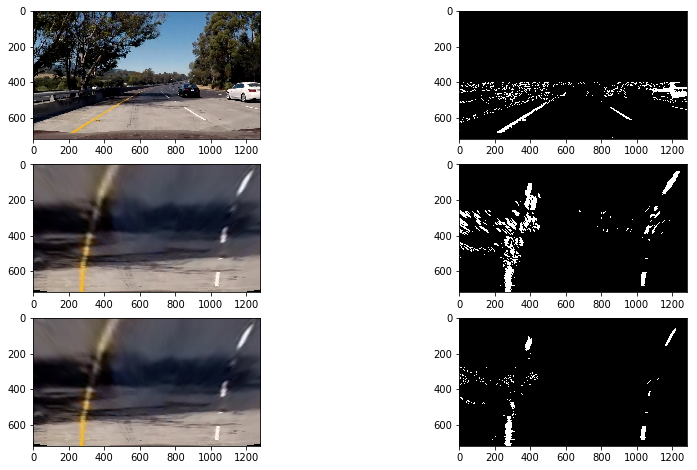

In [116]:
# testing the pipeline
# two verions:
# - extract marikings first, then get bridseye view
# - get bridseye view first, then extract markings

image = imread('test_images/test5.jpg')
binary = lane_markings_binary(image)
birdseye_image, _ = bridseye(image, calibration['mtx'], calibration['dist'])
birdseye_binary, _ = bridseye(binary, calibration['mtx'], calibration['dist'])
birdseye_binary_2 = lane_markings_binary(birdseye_image,0)

figure, axarr = plt.subplots(3, 2, figsize=(14, 8))
axarr[0,0].imshow(image)
axarr[0,1].imshow(binary, cmap='gray')
axarr[1,0].imshow(birdseye_image)
axarr[1,1].imshow(birdseye_binary, cmap='gray')
axarr[2,0].imshow(birdseye_image)
axarr[2,1].imshow(birdseye_binary_2, cmap='gray')

imsave('output_images/test5_thresholded.jpg', binary*255)
imsave('output_images/test5_birdseye.jpg', birdseye_image)
imsave('output_images/test5_thresholded_bridseye.jpg', birdseye_binary*255)
imsave('output_images/test5_bridseye_thresholded.jpg', birdseye_binary_2*255)